In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import geojsoncontour
import folium
from scipy.signal import butter, lfilter, freqz, filtfilt, welch
from matplotlib.patches import Ellipse
from cartopy import crs,feature
pd.options.display.max_rows = 4000

### Some functions 

#### Filtering functions

In [2]:
# from https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass 
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

#https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
def eigsorted(cov):
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]   # The [::-1] slice reverses order sort order is largest to smallest
    return vals[order], vecs[:,order]

#### Functions for xarray

In [3]:
def tmean(x):
    return (x-x.mean())
def bandpassSD(x):
    return butter_bandpass_filter(x, lowcut_sd, highcut_sd, fs, order=3)
def bandpassDI(x):
    return butter_bandpass_filter(x, lowcut_di, highcut_di, fs, order=3)
def bandpassLP(x):
    return butter_lowpass_filter(x, lowcut_lp, fs, order=3)

### Read in dataset from HFRnet TDS OpenDAP into xarray

In [4]:
netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')

### Set Time and Geographical limits

In [5]:
timeStart="2017-09-01T00:00:00"
timeStop="2017-11-01T00:00:00"
latStart=34.55
latStop=35.22
lonStart=-121.35
lonStop=-120.65

from pyproj import Geod
wgs84_geod = Geod(ellps='WGS84')
az12,az21,xdist = wgs84_geod.inv(-121.30252075,34.56520081,-120.67786407,34.56520081)
az12,az21,ydist = wgs84_geod.inv(-121.30252075,34.56520081,-121.30252075,35.21247864)
#34.56520081 35.21247864
#-121.30252075 -120.67786407
print(xdist/1000,ydist/1000)

#coordinates=[[lonStart,latStop],[lonStop,latStop],[lonStop,latStart],[lonStart,latStart]]
#latStart=30
#latStop=36
#lonStart=-125
#lonStop=-117

57.32366561228 71.80806048449148


### Subset the data

In [6]:
data=netcdf_data.sel(time=slice(timeStart,timeStop),lat=slice(latStart,latStop),lon=slice(lonStart,lonStop))

# interpolate
data['uint']=data['u'].interpolate_na(dim='time')
data['vint']=data['v'].interpolate_na(dim='time')

# demean data
data_stacked=data.stack(geo=('lat','lon'))
data['udm']=data_stacked['uint'].groupby('geo').apply(tmean).unstack('geo')
data['vdm']=data_stacked['vint'].groupby('geo').apply(tmean).unstack('geo')

# Create complex timeseries
data['uiv']=data['udm']+1j*data['vdm']




In [7]:
data['uivm']=data['uint']+1j*data['vint']

### Confirm there are no time gaps

In [8]:
# mean,max and min of diff should be the same if there are no gaps
print("Min: {:.0f} Max: {:.0f} Mean: {:.0f}".format(np.min(np.diff(data.time))/np.timedelta64(1, 'm'),np.max(np.diff(data.time))/np.timedelta64(1, 'm'),np.mean(np.diff(data.time))/np.timedelta64(1, 'm')))

# this will plot the difference in timestep through timeseries in minutes
#ax=plt.plot(np.diff(data.time)/np.timedelta64(1, 'm'))


Min: 60 Max: 60 Mean: 60


### Plot data coverage

<IPython.core.display.Javascript object>


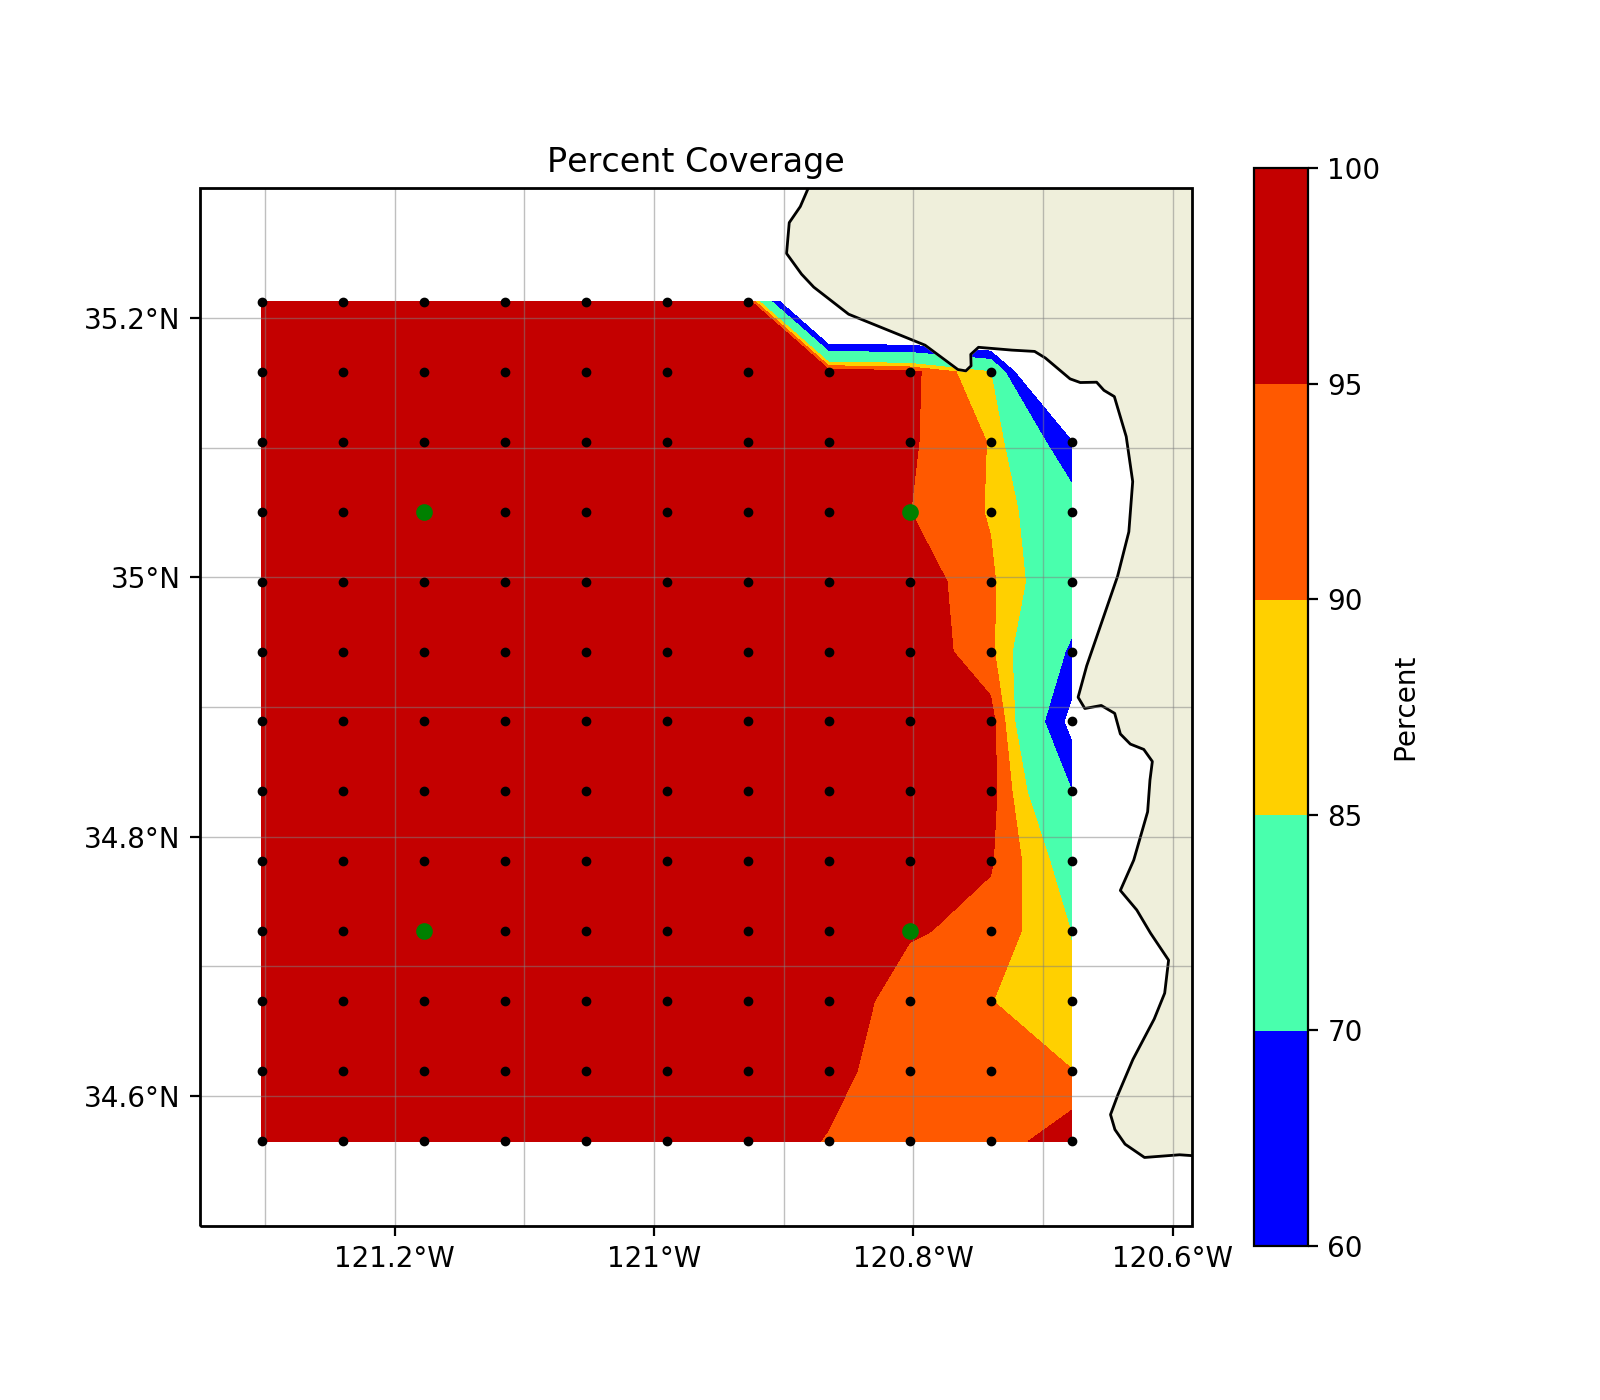

In [9]:
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

percCount=data['u'].count('time')/data['time'].size*100
#(data.u.count('time')/data.time.size*100).plot(cmap='jet')
#ax=plt.plot(lon,lat,'k.')

# lat and lon for plotting
lon,lat=np.meshgrid(data['lon'].values,data['lat'].values)

#find the lat lon with data
udf=percCount.to_dataframe()
udf.reset_index('lat',inplace=True)
udf.reset_index('lon',inplace=True)
glon=udf.lon[udf['u']>0]
glat=udf.lat[udf['u']>0]

#points for analysis
ilat=[3,9,3,9]
ilon=[2,2,8,8]

fig=plt.figure(figsize=(8,7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

cn=ax.contourf(lon,lat,percCount,cmap='jet',levels=[60,70,85,90,95,100])
plt.colorbar(cn,label='Percent')
plt.plot(glon,glat,'k.',ms=5)
plt.plot(data.lon[ilon].values,data.lat[ilat].values,'g.',ms=10)

ax.set_title('Percent Coverage')
ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax.set_extent([-121.35,-120.585,34.5,35.3])
ax.coastlines(resolution='10m',color='k')


# Convert matplotlib contour to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=cn,
    min_angle_deg=3.0,
    ndigits=3,
    stroke_width=2,
    fill_opacity=0.8
)

### Folium Map

In [10]:
style_function = lambda x: {'fillColor': x['properties']['stroke'],'weight':1}
m = folium.Map(
    location=[35, -121],
    tiles='Mapbox Bright',
    zoom_start=9
)
folium.GeoJson(
    geojson,
    name='geojson',
    style_function=style_function
).add_to(m)
m

### design filter

<IPython.core.display.Javascript object>


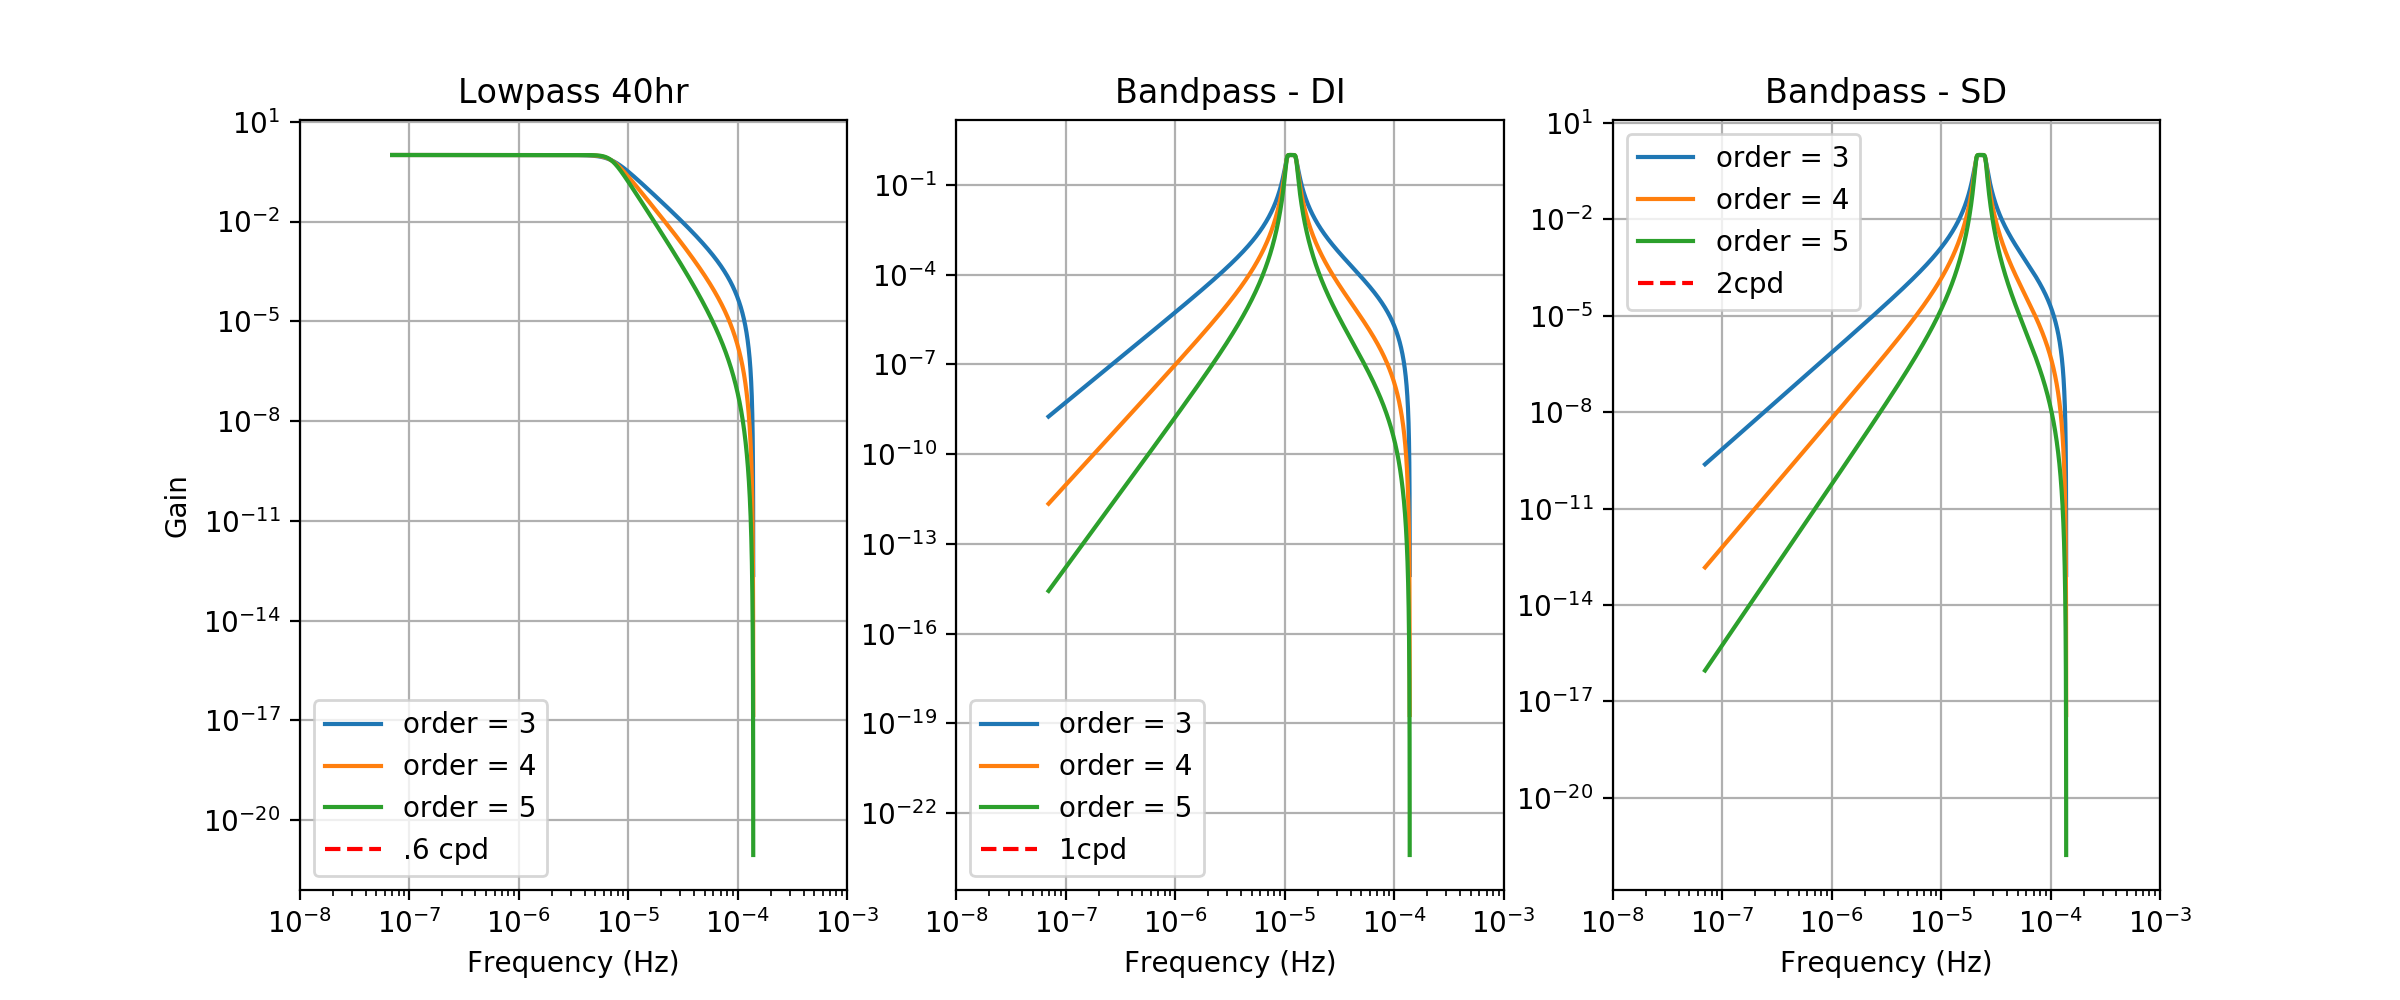

In [11]:
# Sample rate and desired cutoff frequencies (in Hz).
# 1 per hour
fs = 1/3600
lowcut_sd = 1.8/24/3600   # low cut 1.8 cpd
highcut_sd = 2.2/24/3600  #high cut 2.2 cpd

lowcut_di = 0.9/24/3600   # low cut 0.9 cpd
highcut_di = 1.1/24/3600  #high cut 1.1 cpd

lowcut_lp = 1/40/3600     # 40 hr low pass

# Plot the frequency response for a few different orders.
fig1=plt.figure(figsize=(12,5))
ax1_1=plt.subplot(131)
for order in [3, 4, 5]:
    b, a = butter_lowpass(lowcut_lp, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax1_1.loglog((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

ax1_1.loglog([1/40/3600,1/40/3600],[0,1],'r--',label='.6 cpd')
ax1_1.set_xlim((10e-09,10e-04))
ax1_1.set_xlabel('Frequency (Hz)')
ax1_1.set_ylabel('Gain')
ax1_1.set_title('Lowpass 40hr')
ax1_1.grid(True)
ax1_1.legend(loc='best')

ax1_2=plt.subplot(132)
for order in [3, 4, 5]:
    b, a = butter_bandpass(lowcut_di, highcut_di, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax1_2.loglog((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

ax1_2.loglog([1/24/3600,1/24/3600],[0,1],'r--',label='1cpd')
ax1_2.set_xlim((10e-09,10e-04))
ax1_2.set_xlabel('Frequency (Hz)')
ax1_2.set_title('Bandpass - DI')
ax1_2.grid(True)
ax1_2.legend(loc='best')

ax1_3=plt.subplot(133)
for order in [3, 4, 5]:
    b, a = butter_bandpass(lowcut_sd, highcut_sd, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    ax1_3.loglog((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

ax1_3.loglog([2/24/3600,2/24/3600],[0,1],'r--',label='2cpd')
ax1_3.set_xlim((10e-09,10e-04))
ax1_3.set_xlabel('Frequency (Hz)')
ax1_3.set_title('Bandpass - SD')
ax1_3.grid(True)
ax1_3.legend(loc='best')


### Filter currents

In [12]:
# https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
data['usd']=data_stacked['uint'].isel(time=slice(1,1455)).groupby('geo').apply(bandpassSD).unstack('geo')
data['vsd']=data_stacked['vint'].isel(time=slice(1,1455)).groupby('geo').apply(bandpassSD).unstack('geo')

data['udi']=data_stacked['uint'].groupby('geo').apply(bandpassDI).unstack('geo')
data['vdi']=data_stacked['vint'].groupby('geo').apply(bandpassDI).unstack('geo')

data['ulp']=data_stacked['uint'].groupby('geo').apply(bandpassLP).unstack('geo')
data['vlp']=data_stacked['vint'].groupby('geo').apply(bandpassLP).unstack('geo')


### Plot currents

In [13]:
# create time variable for plotting purposes
dates=data.time.to_pandas()

# lat and lon indices
# use .sel if you want to show actual lat and lon values
ilat=8
ilon=9
pdata=data.isel(lat=ilat,lon=ilon)

filtu=pdata['usd']+pdata['ulp']+pdata['udi']
filtv=pdata['vsd']+pdata['vlp']+pdata['vdi']

resu=pdata['uint']-filtu
resv=pdata['vint']-filtv

ssum_resu=np.sum(resu**2)
ssum_resv=np.sum(resv**2)

ssum_filtu=np.sum(filtu**2)
ssum_filtv=np.sum(filtv**2)

ssum_u=np.sum(pdata['uint']**2)
ssum_v=np.sum(pdata['vint']**2)


print(ssum_filtu/ssum_u,ssum_filtv/ssum_v)

<xarray.DataArray ()>
array(0.765265)
Coordinates:
    lat      float64 35.0
    lon      float64 -120.7 <xarray.DataArray ()>
array(0.905874)
Coordinates:
    lat      float64 35.0
    lon      float64 -120.7


<IPython.core.display.Javascript object>


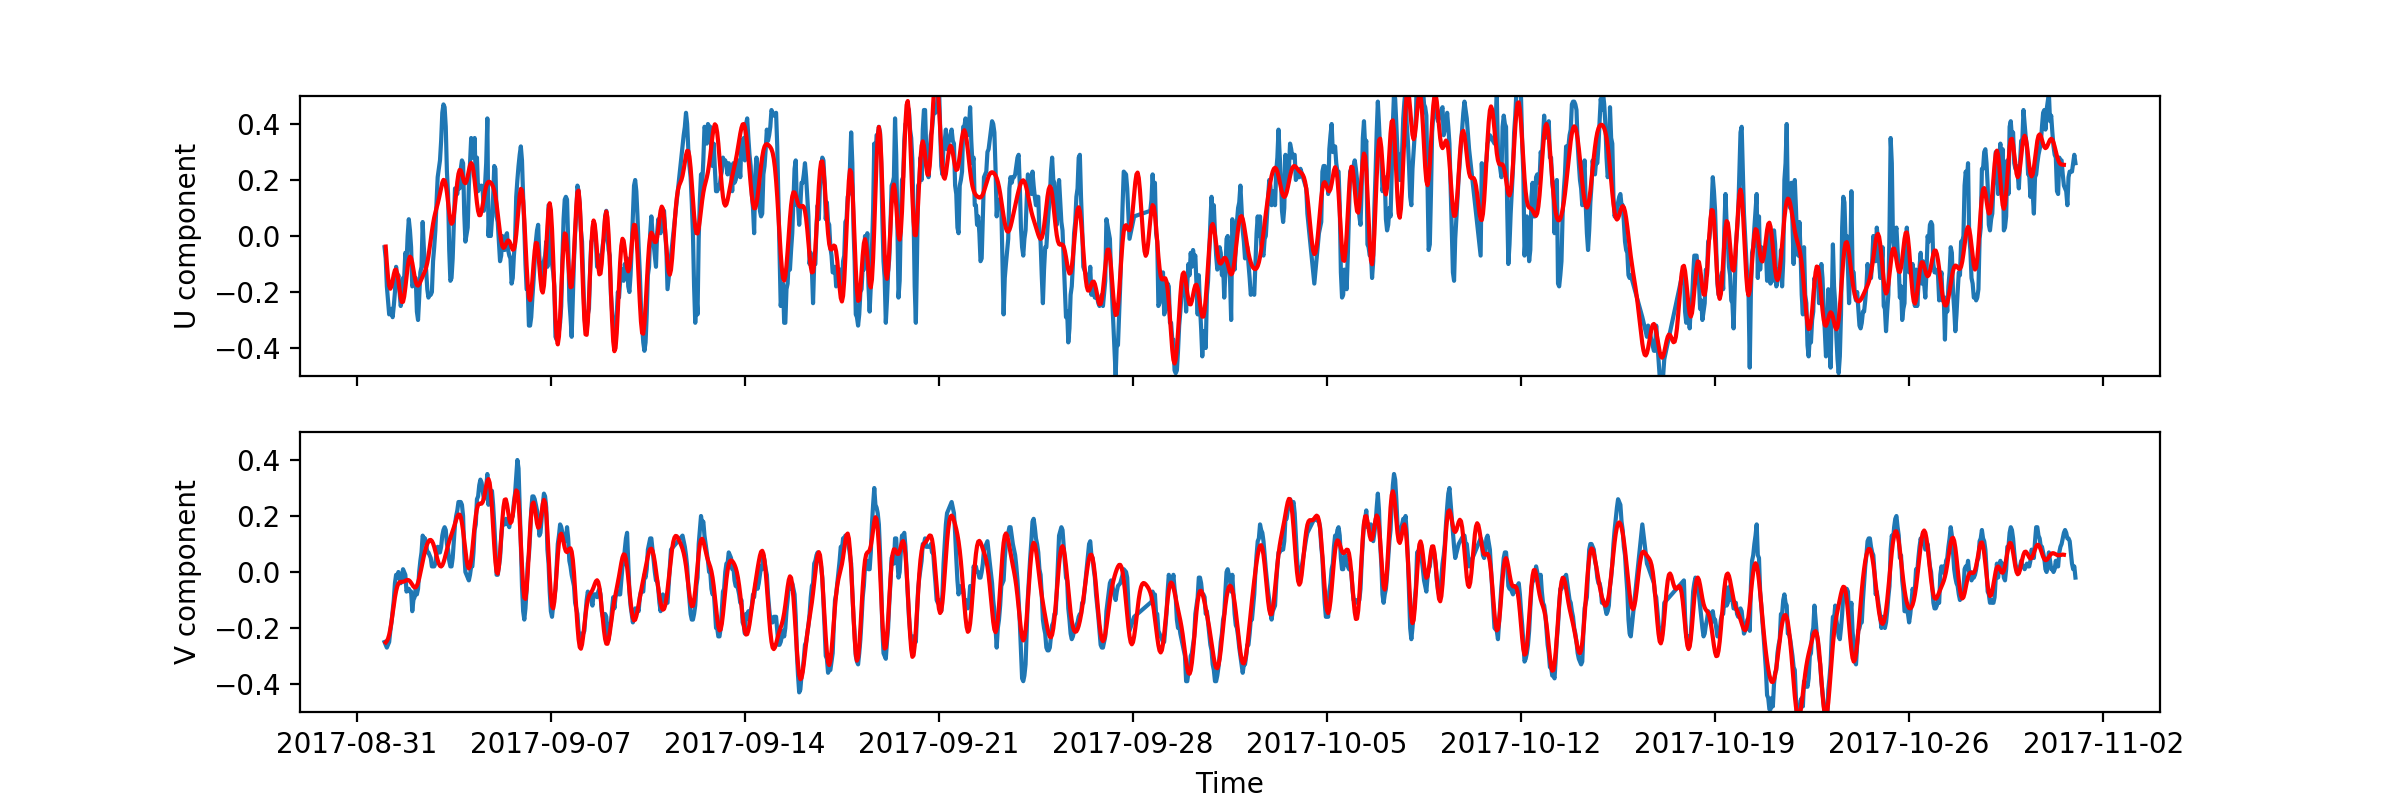

In [14]:
fig3=plt.figure(figsize=(12,4))
ax3_1=plt.subplot(211)
ax3_1.plot(dates,pdata['uint'])

ax3_2=plt.subplot(212)
ax3_2.plot(dates,pdata['vint'])

ax3_1.plot(dates,pdata['usd']+pdata['ulp']+pdata['udi'],'r')
ax3_2.plot(dates,pdata['vsd']+pdata['vlp']+pdata['vdi'],'r')
ax3_2.set_ylim([-.5,.5])
ax3_1.set_ylim([-.5,.5])
ax3_1.xaxis.set_ticklabels([])
ax3_2.set_xlabel('Time')
ax3_2.set_ylabel('V component')
ax3_1.set_ylabel('U component')

### Plot Rotary spectra

<IPython.core.display.Javascript object>


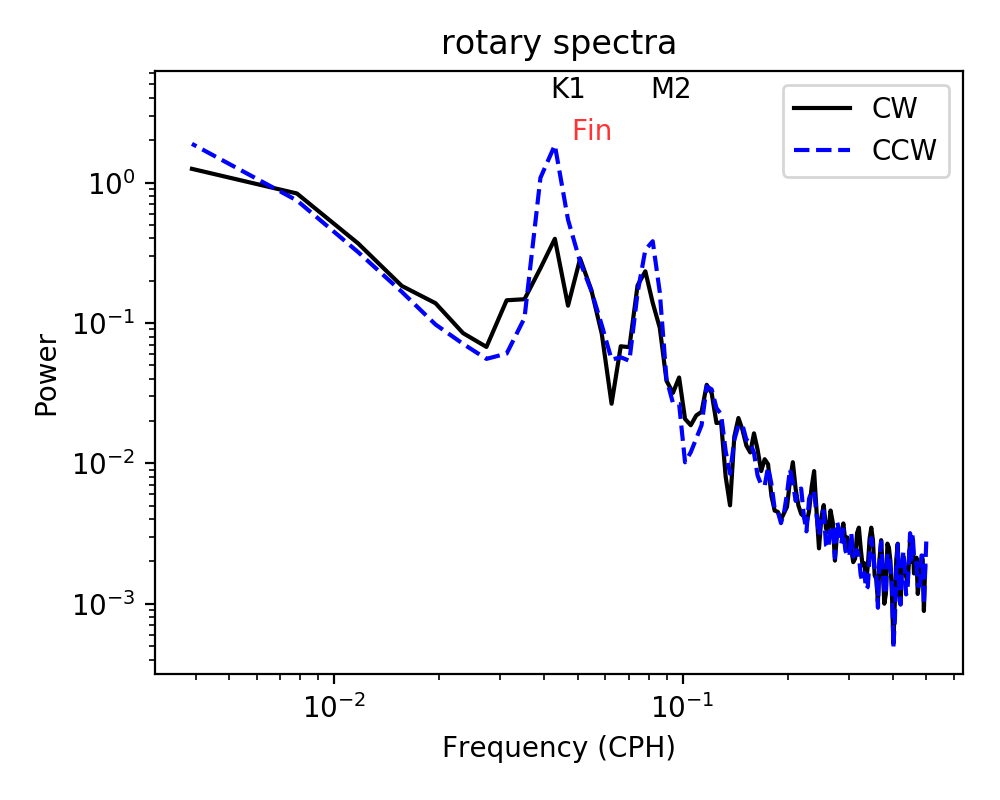

In [15]:
freqs, psd = welch(pdata.uiv,return_onesided=False)
#freqs, psd = welch(pdata['udi']+1j*pdata['vdi'],return_onesided=False)


freqCW = freqs[np.where(freqs>0)]
psdCW = psd[np.where(freqs>0)]
freqCCW = freqs[np.where(freqs<0)]
psdCCW = psd[np.where(freqs<0)]

# plot
fig4=plt.figure(figsize=(5, 4))
ax4=plt.subplot()
ax4.loglog(freqCW, psdCW,'k-',label="CW")
ax4.loglog(-freqCCW, psdCCW,'b--',label="CCW")
ax4.loglog([1/12.42,1/12.42],[0,4],':',color='#3333ff',linewidth=.75)
ax4.loglog([1/23.93,1/23.93],[0,4],':',color='#3333ff',linewidth=.75)
ax4.loglog([1/20.921,1/20.921],[0,4],':',color='#ff3333',linewidth=.75)
ax4.text(1/20.921,2,'Fin',color='#ff3333')
ax4.text(1/23.93,4,'K1')
ax4.text(1/12.42,4,'M2')


ax4.legend()
plt.title('rotary spectra')
plt.xlabel('Frequency (CPH)')
plt.ylabel('Power')
plt.tight_layout()

### Find variance ellipses of semidiurnal currents

In [17]:
nstd = 2  # #of std dev to draw ellipse around data
#del data['varwu']
#del data['varwv']
#del data['varhu']
#del data['varhv']

data['varwu']=data['usd'].var('time')
data['varwv']=data['vsd'].var('time')
data['varhu']=data['usd'].var('time')
data['varhv']=data['vsd'].var('time')
data['varh']=data['vsd'].var('time')
data['varw']=data['vsd'].var('time')
data['vart']=data['vsd'].var('time')
data['vartsd']=data['vsd'].var('time')
data['varhsd']=data['vsd'].var('time')
data['varwsd']=data['vsd'].var('time')
data['varwusd']=data['usd'].var('time')
data['varwvsd']=data['vsd'].var('time')
data['varhusd']=data['usd'].var('time')
data['varhvsd']=data['vsd'].var('time')

#fig7=plt.figure()
#ax7 = plt.subplot(111,aspect='equal')
#del data['varw']
for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        try:
            cu=np.nan_to_num(data['uint'][:,i,j])
            cv=np.nan_to_num(data['vint'][:,i,j])
            cov = np.cov(cu,cv)
            vals, vecs = eigsorted(cov)
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            w, h = 2 * nstd * np.sqrt(vals) # typically major axis = 1st EV, minor axis = 2nd EV
            data['varhu'][i,j]=w*np.sin(theta)
            data['varhv'][i,j]=w*np.cos(theta)        
            data['varwu'][i,j]=h*np.sin(theta+np.deg2rad(90))
            data['varwv'][i,j]=h*np.cos(theta+np.deg2rad(90))
            data['varh'][i,j]=h
            data['varw'][i,j]=w
            data['vart'][i,j]=theta
            cu=np.nan_to_num(data['usd'][:,i,j])
            cv=np.nan_to_num(data['vsd'][:,i,j])
            cov = np.cov(cu,cv)
            vals, vecs = eigsorted(cov)
            theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
            w, h = 2 * nstd * np.sqrt(vals) # typically major axis = 1st EV, minor axis = 2nd EV
            data['varhusd'][i,j]=w*np.sin(theta)
            data['varhvsd'][i,j]=w*np.cos(theta)        
            data['varwusd'][i,j]=h*np.sin(theta+np.deg2rad(90))
            data['varwvsd'][i,j]=h*np.cos(theta+np.deg2rad(90))
            data['varhsd'][i,j]=h
            data['varwsd'][i,j]=w
            data['vartsd'][i,j]=theta
        except:
            print('missed,',np.nan_to_num(data['uint'][:,i,j]))
            print(cov)

#data.lat.loc

<IPython.core.display.Javascript object>


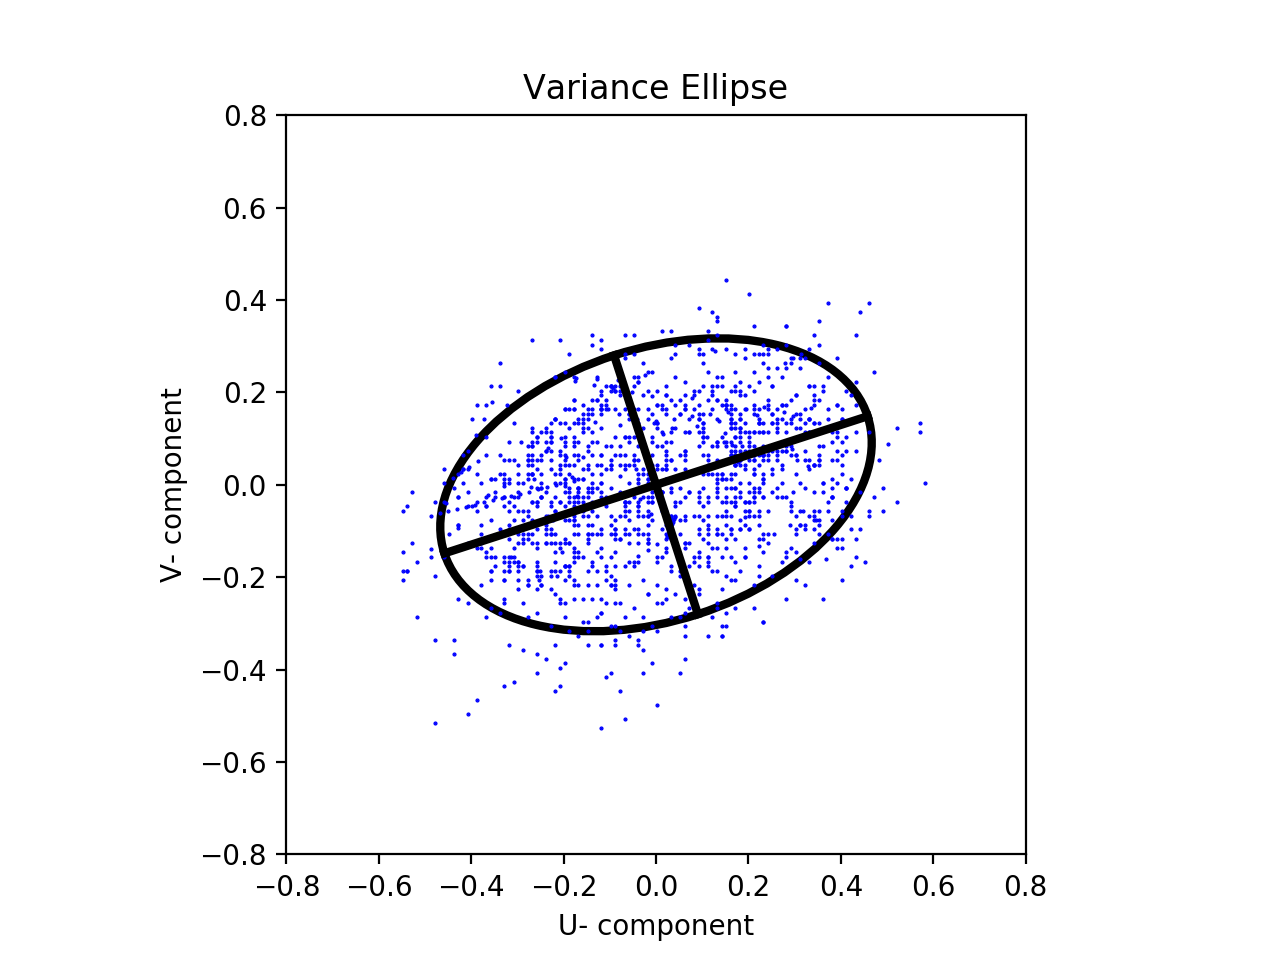

In [18]:
u=pdata['udm']
v=pdata['vdm']
fig7=plt.figure()
ax7 = plt.subplot(111,aspect='equal')
cov = np.cov(u,v)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals) # typically major axis = 1st EV, minor axis = 2nd EV
#w, h = 2 * nstd * vals 
ell = Ellipse(xy=(np.mean(u), np.mean(v)),
              width=w, height=h,
              angle=theta, color='black',linewidth=3)
ell.set_facecolor('none')
ax7.add_patch(ell)
ax7.plot(u, v,'b.',ms=1)

endy=w/2*np.sin(np.deg2rad(theta))
endx=w/2*np.cos(np.deg2rad(theta))
endyy=h/2*np.sin(np.deg2rad(theta+90))
endxx=h/2*np.cos(np.deg2rad(theta+90))


ax7.plot([0,endx],[0,endy],'k',linewidth=3)
ax7.plot([0,endxx],[0,endyy],'k',linewidth=3)
ax7.plot([0,-endx],[0,-endy],'k',linewidth=3)
ax7.plot([0,-endxx],[0,-endyy],'k',linewidth=3)

#ax7.set_xlim([-.35,.35])
#ax7.set_ylim([-.35,.35])
ax7.set_xlim([-.8,.8])
ax7.set_ylim([-.8,.8])
ax7.set_xlabel('U- component')
ax7.set_ylabel('V- component')
ax7.set_title('Variance Ellipse')

### Current mean

<IPython.core.display.Javascript object>


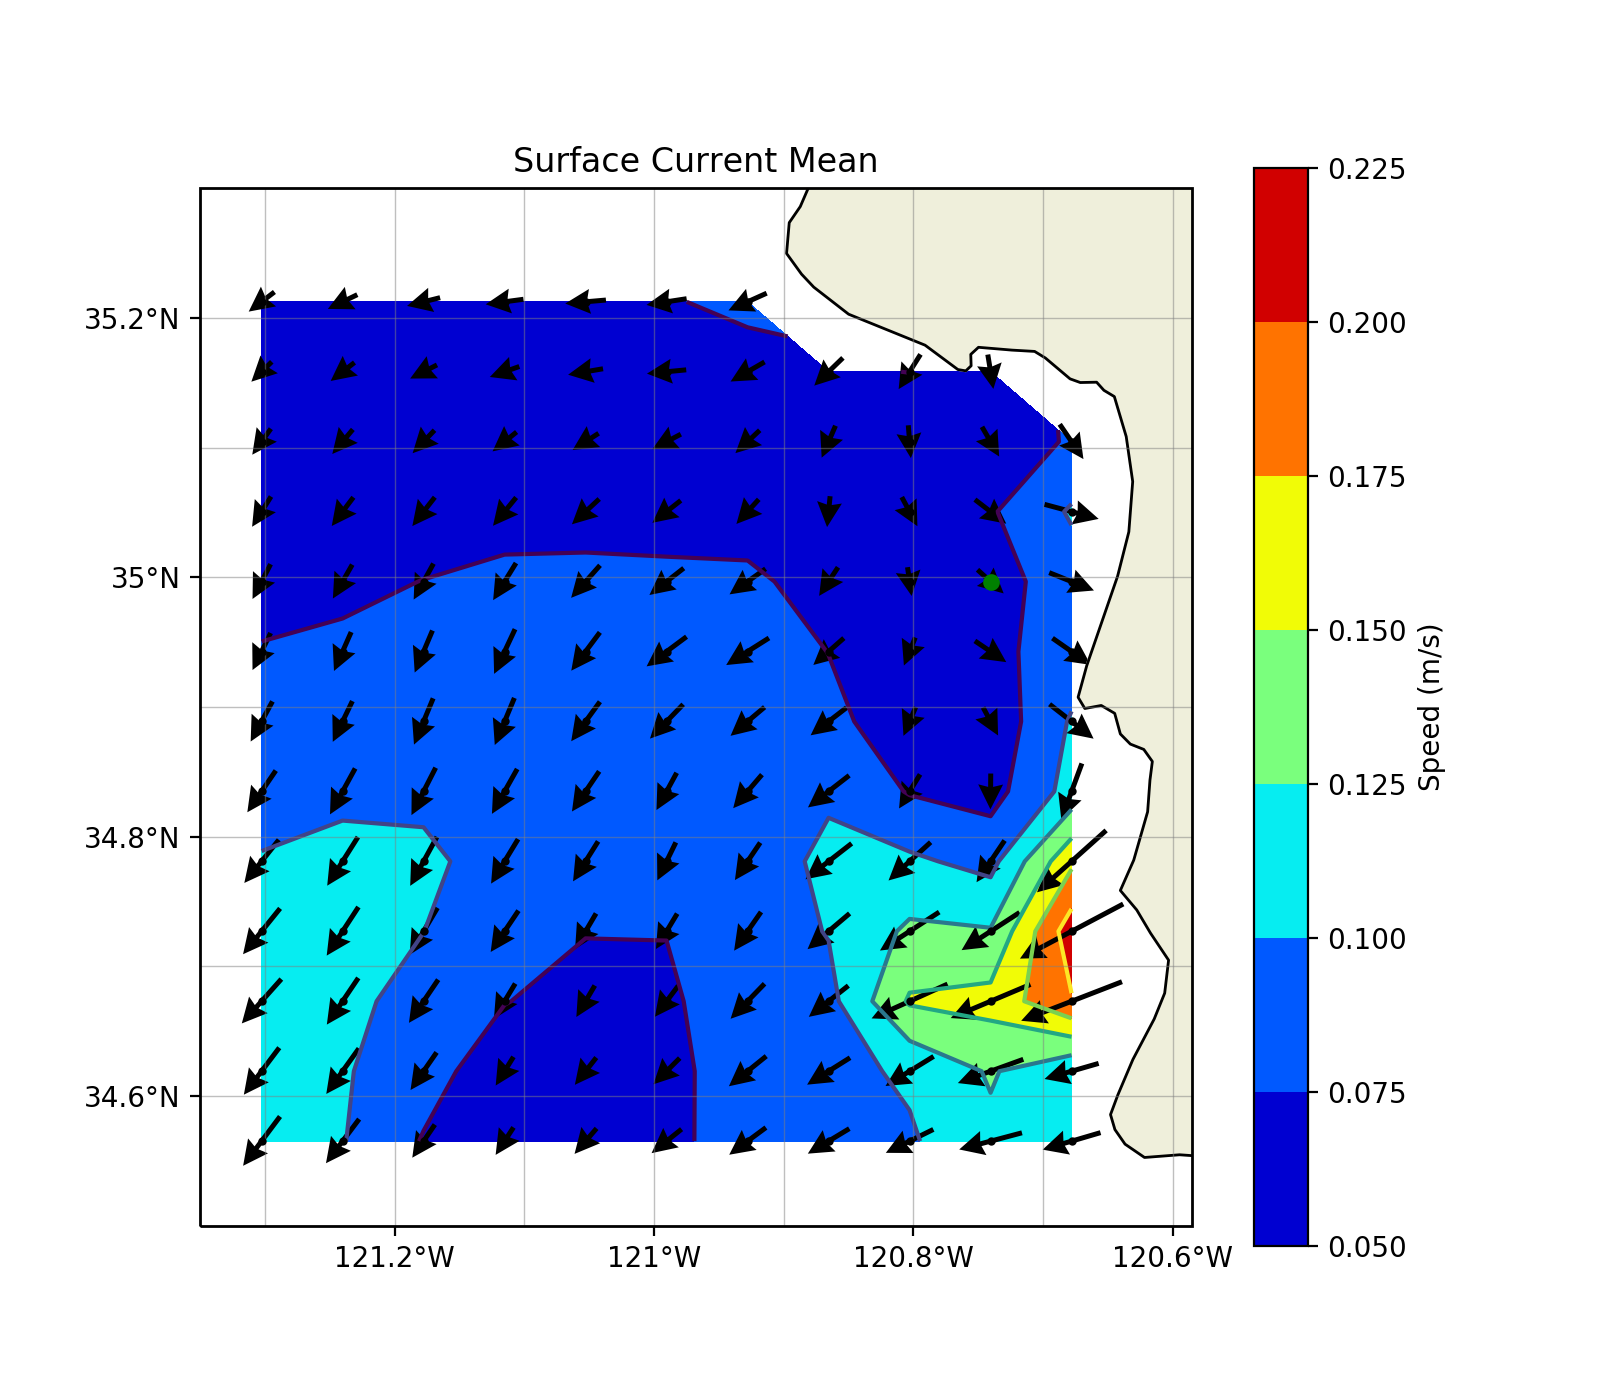

In [19]:
meanMag=np.sqrt(data['uint'].mean('time')**2+data['vint'].mean('time')**2)
meanDir=np.rad2deg(np.arctan2(data['vint'].mean('time'),data['uint'].mean('time')))

fig=plt.figure(figsize=(8,7))
#ell = Ellipse(xy=(-121,35),
#              width=w/5, height=h/5,
#              angle=theta, color='black',linewidth=1)
#ell.set_facecolor('none')
#ax8.add_patch(ell)
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())

ax8.set_title('Surface Current Mean')
ax8.set_extent([-121.35,-120.585,34.5,35.3])
#ax8.contourf(lon,lat,percCount,cmap='jet',levels=[.025,.05,.1,.15,.2])
#ax8.contour(lon,lat,percCount,levels=[.025,.05,.1,.15,.2])
CF=ax8.contourf(lon,lat,meanMag,cmap='jet')
ax8.contour(lon,lat,meanMag)
ax8.quiver(lon,lat,data['uint'].mean('time'),data['vint'].mean('time'),headwidth=5,pivot='mid')
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.plot(glon,glat,'k.',ms=4)
plt.plot(data.lon[ilon].values,data.lat[ilat].values,'g.',ms=10)
plt.colorbar(CF,label="Speed (m/s)")
ax8.coastlines(resolution='10m',color='k')

<IPython.core.display.Javascript object>


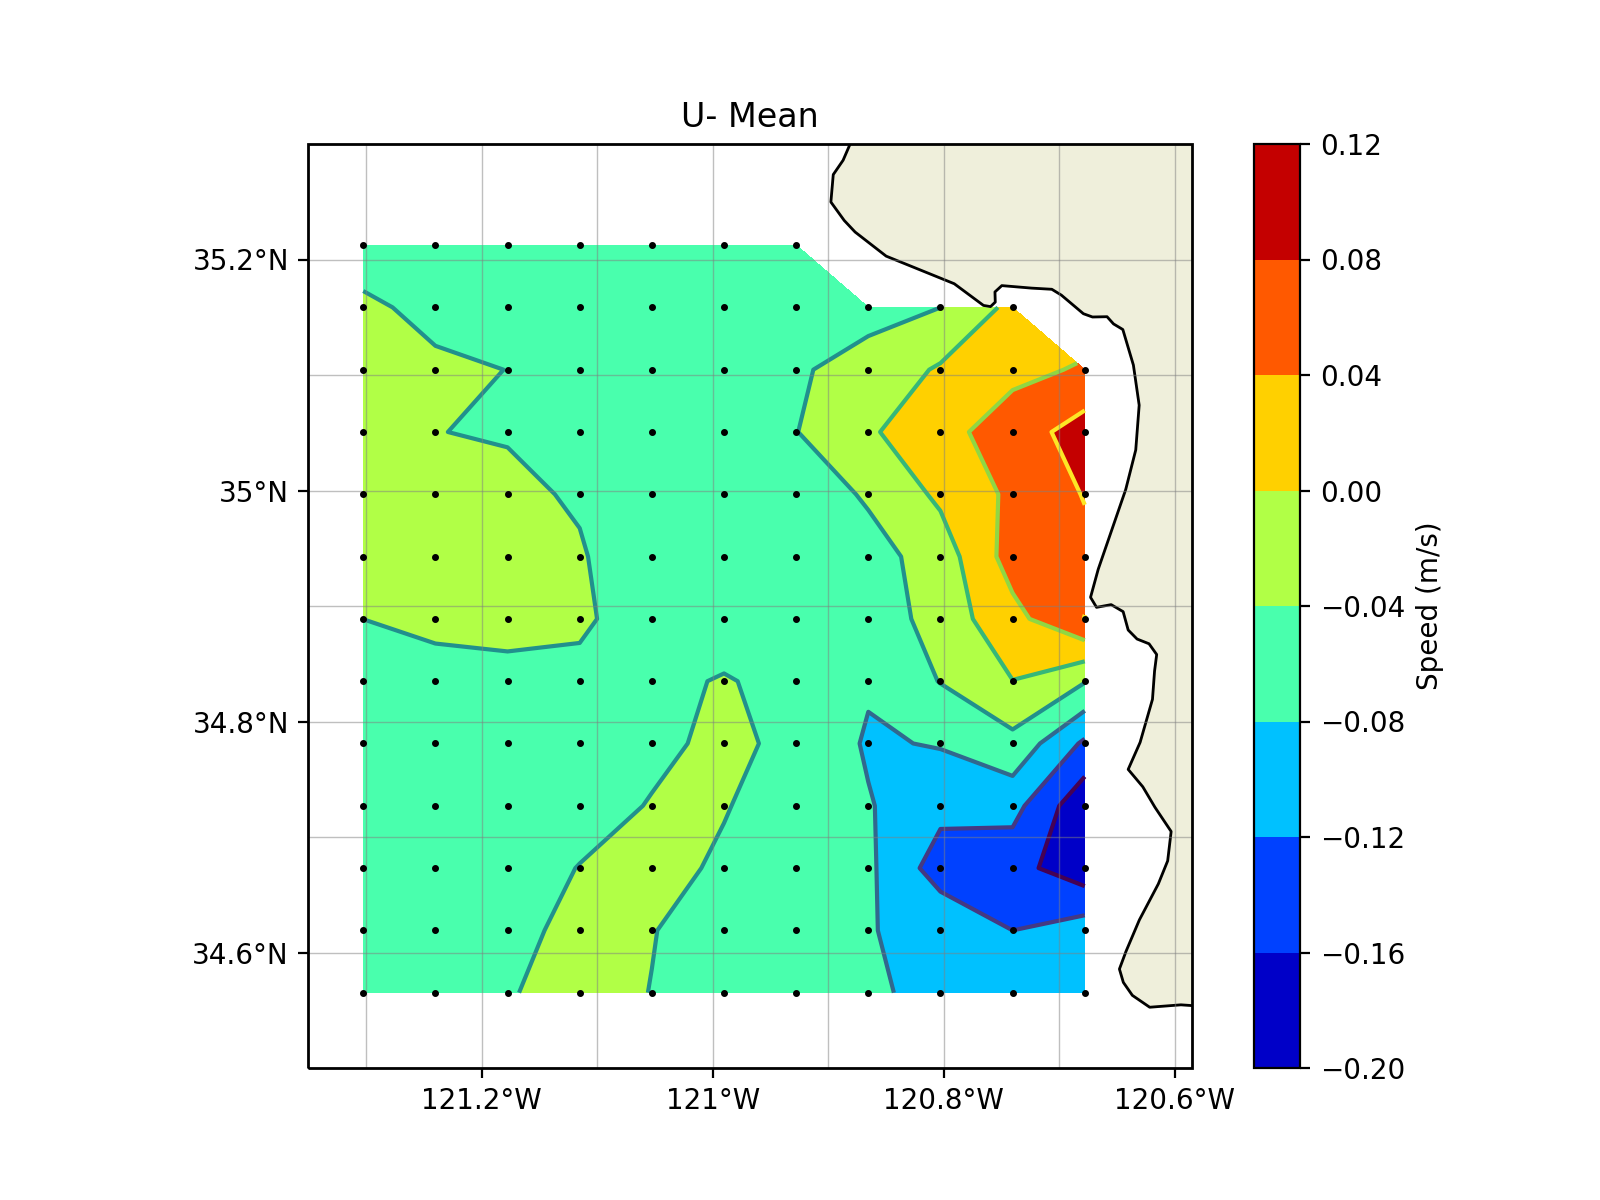

<IPython.core.display.Javascript object>


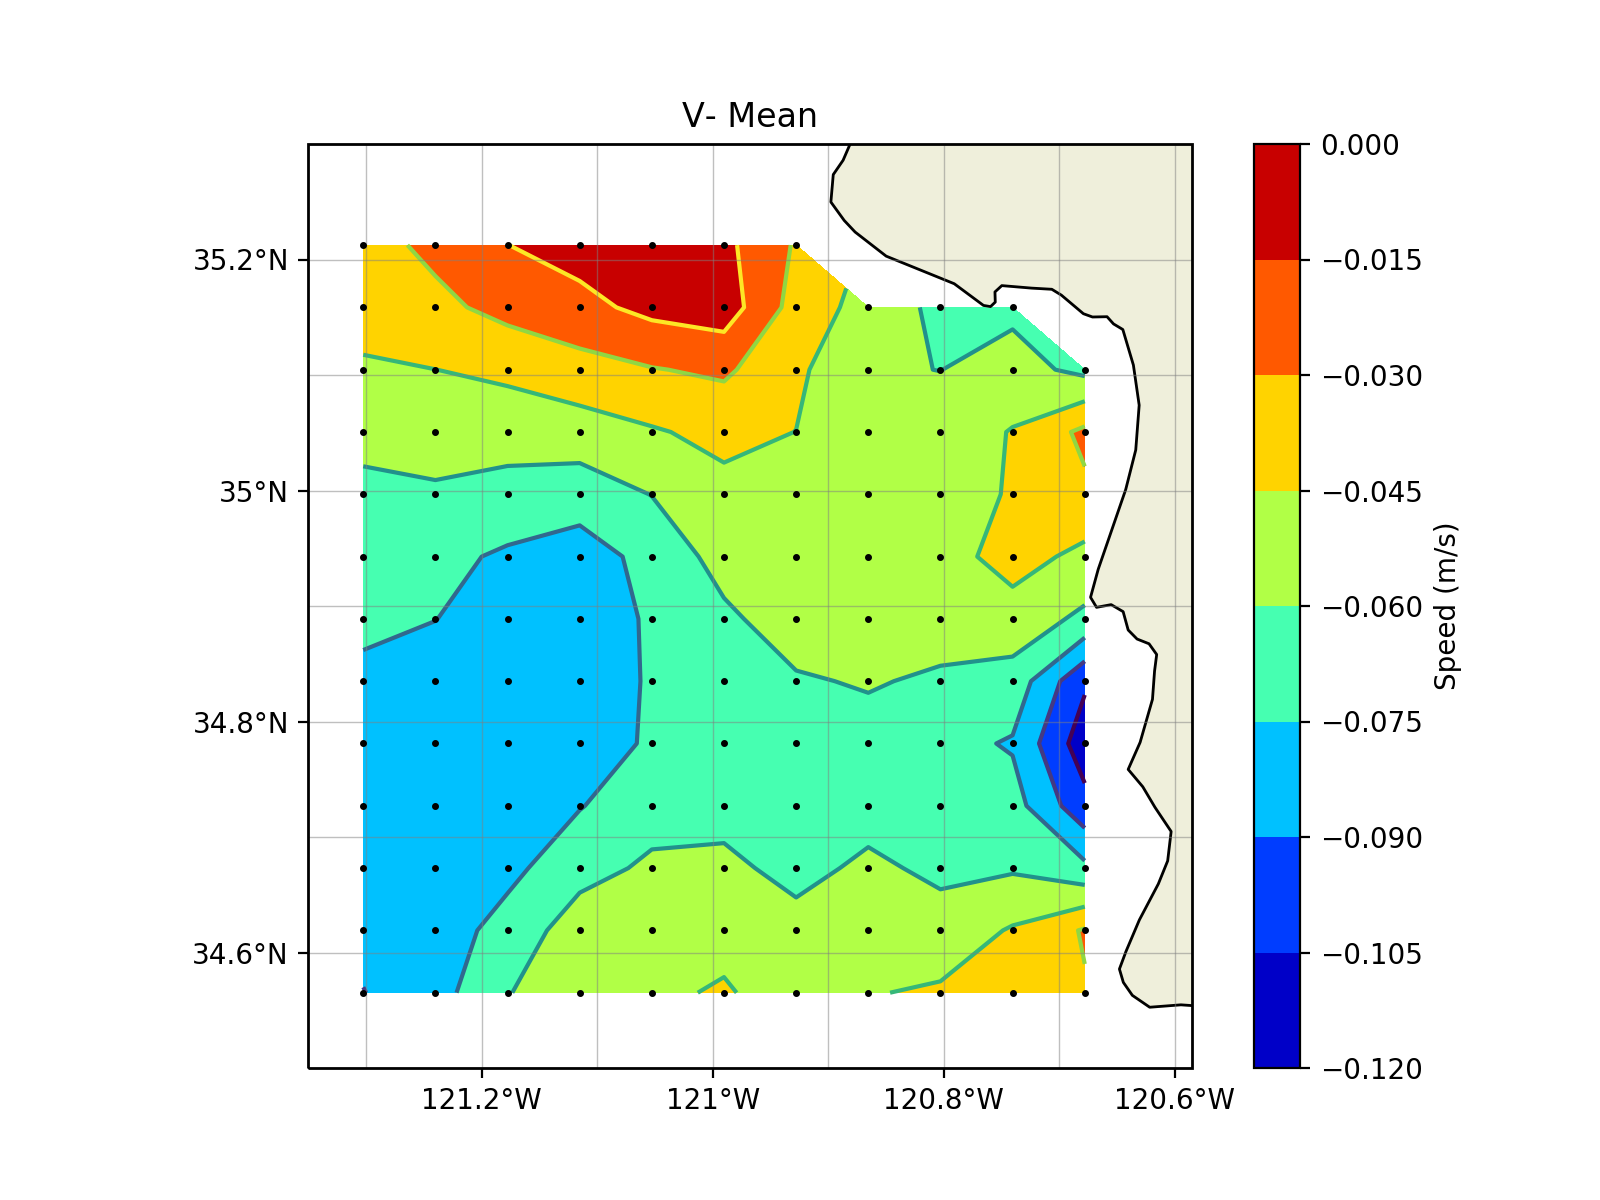

In [20]:

fig=plt.figure(figsize=(8,6))
ax9 = plt.axes(projection=crs.PlateCarree())
ax9.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax9.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax9.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax9.xaxis.set_major_formatter(LongitudeFormatter())
ax9.yaxis.set_major_formatter(LatitudeFormatter())

ax9.set_title('U- Mean')
ax9.set_extent([-121.35,-120.585,34.5,35.3])
CF=ax9.contourf(lon,lat,data['uint'].mean('time'),cmap='jet')
ax9.contour(lon,lat,data['uint'].mean('time'))
plt.colorbar(CF,label="Speed (m/s)")
ax9.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax9.plot(glon,glat,'k.',ms=3)
ax9.coastlines(resolution='10m',color='k')

fig=plt.figure(figsize=(8,6))
ax10 = plt.axes(projection=crs.PlateCarree())
ax10.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax10.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax10.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax10.xaxis.set_major_formatter(LongitudeFormatter())
ax10.yaxis.set_major_formatter(LatitudeFormatter())

ax10.set_title('V- Mean')
ax10.set_extent([-121.35,-120.585,34.5,35.3])
CFx=ax10.contourf(lon,lat,data['vint'].mean('time'),cmap='jet')
ax10.contour(lon,lat,data['vint'].mean('time'))
plt.colorbar(CFx,label="Speed (m/s)")

ax10.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax10.plot(glon,glat,'k.',ms=3)
ax10.coastlines(resolution='10m',color='k')

### Current variance

<IPython.core.display.Javascript object>


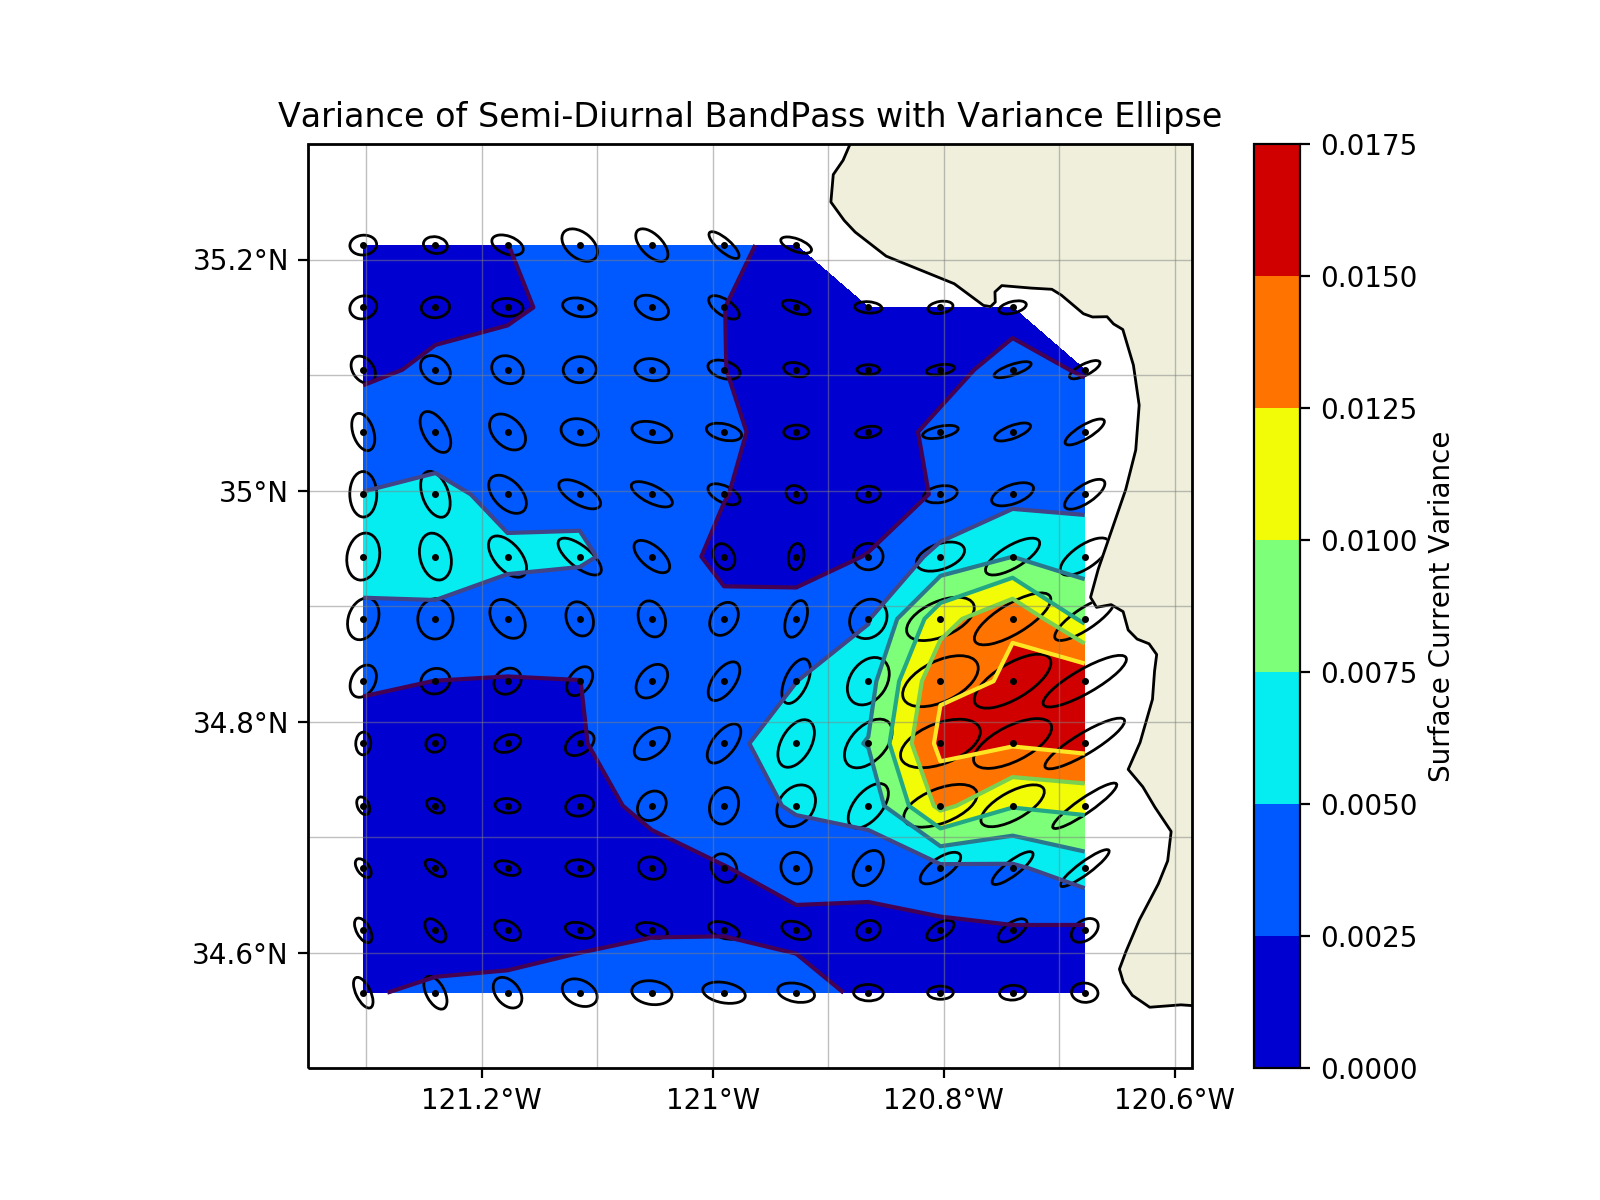

In [21]:
variance=np.sqrt(data['usd'].isel(time=slice(2,1460)).var('time')**2+data['vsd'].isel(time=slice(2,1460)).var('time')**2)
#variance=data['uiv'].var('time')
#varAngle=np.rad2deg(np.arctan2(np.imag(data['uiv'])/np.real(data['uiv'])))
fig=plt.figure(figsize=(8,6))
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())
for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        w=np.sqrt(data['varwusd'].isel(lat=i,lon=j)**2+data['varwvsd'].isel(lat=i,lon=j)**2)
        h=np.sqrt(data['varhusd'].isel(lat=i,lon=j)**2+data['varhvsd'].isel(lat=i,lon=j)**2)
        w=data['varwsd'].isel(lat=i,lon=j)
        h=data['varhsd'].isel(lat=i,lon=j)
        theta=data['vartsd'].isel(lat=i,lon=j)
        
        ell = Ellipse(xy=(data.lon.isel(lon=j),data.lat.isel(lat=i)),
              width=w/7, height=h/7,
              angle=theta, color='black',linewidth=1)
        ell.set_facecolor('none')
        ax8.add_patch(ell)
        
ax8.set_extent([-121.35,-120.585,34.5,35.3])

CF=ax8.contourf(lon,lat,variance,cmap='jet')
ax8.contour(lon,lat,variance)
#ax8.quiver(lon,lat,data['varwusd'],data['varwvsd'],headwidth=0)
#ax8.quiver(lon,lat,data['varhusd'],data['varhvsd'],headwidth=0)
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.plot(glon,glat,'k.',ms=3)
ax8.set_title('Variance of Semi-Diurnal BandPass with Variance Ellipse')
plt.colorbar(CF,label="Surface Current Variance")
ax8.coastlines(resolution='10m',color='k')




<IPython.core.display.Javascript object>


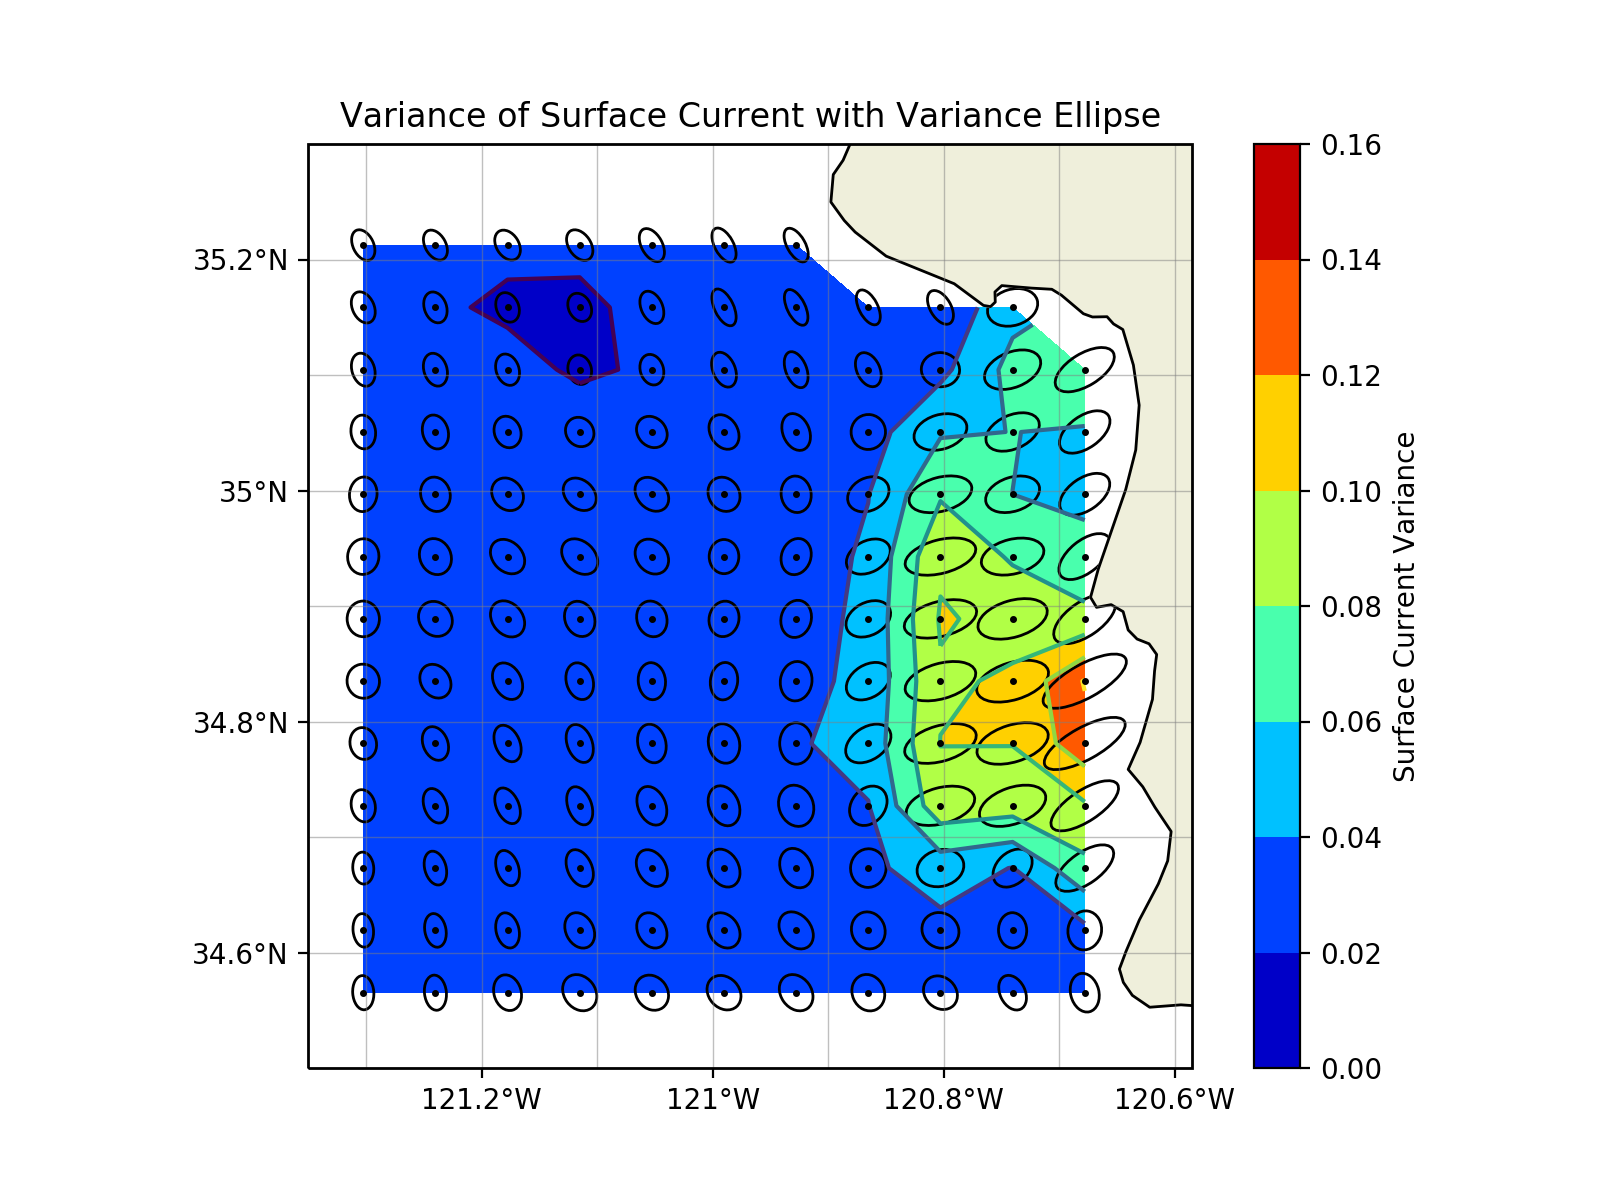

In [26]:
variance=np.sqrt(data['uint'].var('time')**2+data['vint'].var('time')**2)
#variance=data['uiv'].var('time')
#varAngle=np.rad2deg(np.arctan2(np.imag(data['uiv'])/np.real(data['uiv'])))
fig=plt.figure(figsize=(8,6))
ax8 = plt.axes(projection=crs.PlateCarree())
ax8.set_xticks([-121.2,-121.0,-120.8,-120.6], crs=crs.PlateCarree())
ax8.set_yticks([34.4,34.6,34.8,35,35.2], crs=crs.PlateCarree())
ax8.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')
ax8.xaxis.set_major_formatter(LongitudeFormatter())
ax8.yaxis.set_major_formatter(LatitudeFormatter())
#ell = Ellipse(xy=(-121,35),
#              width=w/5, height=h/5,
#              angle=theta, color='black',linewidth=1)
#ell.set_facecolor('none')
#ax8.add_patch(ell)
for i in np.arange(0,data.lat.size):
    for j in np.arange(0,data.lon.size):
        w=np.sqrt(data['varwu'].isel(lat=i,lon=j)**2+data['varwv'].isel(lat=i,lon=j)**2)
        h=np.sqrt(data['varhu'].isel(lat=i,lon=j)**2+data['varhv'].isel(lat=i,lon=j)**2)
        w=data['varw'].isel(lat=i,lon=j)
        h=data['varh'].isel(lat=i,lon=j)
        theta=data['vart'].isel(lat=i,lon=j)
        
        ell = Ellipse(xy=(data.lon.isel(lon=j),data.lat.isel(lat=i)),
              width=w/20, height=h/20,
              angle=theta, color='black',linewidth=1)
        ell.set_facecolor('none')
        ax8.add_patch(ell)
ax8.set_extent([-121.35,-120.585,34.5,35.3])

CF=ax8.contourf(lon,lat,variance,cmap='jet')
ax8.contour(lon,lat,variance)
#ax8.quiver(lon,lat,data['varwu'],data['varwv'],headwidth=0)
#ax8.quiver(lon,lat,data['varhu'],data['varhv'],headwidth=0)
ax8.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
ax8.plot(glon,glat,'k.',ms=3)
ax8.set_title('Variance of Surface Current with Variance Ellipse')
plt.colorbar(CF,label="Surface Current Variance")
ax8.coastlines(resolution='10m',color='k')




In [ ]:
vals, vecs = np.linalg.eig(cov)
vals[vals.argsort()[::-1]]
gvecs=vecs[:,vals.argsort()[::-1]]
np.rad2deg(np.arctan2(*gvecs[:,0][::-1]))
vals
#cov = np.cov(u,v)
#vals, vecs = eigsorted(cov)
#theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
#w, h = 2 * nstd * np.sqrt(vals)

In [ ]:
gvecs[:,0]

In [ ]:
data['umean']=data['u'].mean('time')

In [ ]:
np.arange(0,data.lat.size)

In [ ]:
data.lon.values


In [ ]:
np.deg2rad(90)*2

In [ ]:
data.time.isel(time=slice(1,1464))

In [ ]:
data['uint'].isel(lat=6,lon=10,time=slice(1,1455)).to_series()

In [ ]:
data.lat.isel(lat=i)

In [ ]:
data